# import 

In [1]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

import plotly as plty


# data

Variable Name	    Description

LoanNr_ChkDgt	    Identifier Primary key

Name	            Borrower name

City	            Borrower city

State	            Borrower state

Zip	                Borrower zip code

Bank	            Bank name

BankState	        Bank state

NAICS	            North American industry classification system code

ApprovalDate	    Date SBA commitment issued

ApprovalFY	        Fiscal year of commitment

Term	            Loan term in months

NoEmp	            Number of business employees

NewExist	        1 = Existing business, 2 = New business

CreateJob	        Number of jobs created

RetainedJob	        Number of jobs retained

FranchiseCode	    Franchise code, (00000 or 00001) = No franchise

UrbanRural	        1 = Urban, 2 = rural, 0 = undefined

RevLineCr	        Revolving line of credit: Y = Yes, N = No
    
LowDoc	            LowDoc Loan Program: Y = Yes, N = No
    
ChgOffDate	        The date when a loan is declared to be in default

DisbursementDate	Disbursement date

DisbursementGross	Amount disbursed

BalanceGross	    Gross amount outstanding

MIS_Status	        Loan status charged off = CHGOFF, Paid in full =PIF

ChgOffPrinGr	    Charged-off amount

GrAppv	            Gross amount of loan approved by bank

SBA_Appv	        SBA’s guaranteed amount of approved loan

In [2]:
df = pd.read_csv('explore.csv',index_col= 0 )

/var/folders/d0/5dr5q0n145vcn3_m9dxy1xq80000gn/T/ipykernel_58233/711269991.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('explore.csv',index_col= 0 )


In [3]:
def camel_to_snake(column_name):
    """Converts a camel case string to snake case"""
    snake_name = ''
    for i, char in enumerate(column_name):
        if i == 0:
            snake_name += char.lower()
        elif char.isupper():
            snake_name += '_' + char.lower()
        else:
            snake_name += char
    return snake_name

In [4]:
df = df[(df['LowDoc'] == 'N') | (df['LowDoc'] == 'Y')]

In [5]:
df = df[(df['RevLineCr'] == 'N') | (df['RevLineCr'] == 'Y')]


In [6]:

snake_case_columns = [camel_to_snake(col) for col in df]

In [7]:
snake_case_columns

['city',
 'state',
 'zip',
 'bank',
 'bank_state',
 'n_a_i_c_s',
 'approval_date',
 'approval_f_y',
 'term',
 'no_emp',
 'new_exist',
 'create_job',
 'retained_job',
 'franchise_code',
 'urban_rural',
 'rev_line_cr',
 'low_doc',
 'chg_off_date',
 'disbursement_date',
 'disbursement_gross',
 'balance_gross',
 'm_i_s__status',
 'chg_off_prin_gr',
 'gr_appv',
 's_b_a__appv']

In [8]:
# lis = df.columns.tolist()

In [9]:
# lis = [x.lower() for x in lis]

In [10]:
df.columns = snake_case_columns

In [11]:
df = df.drop(columns = ['approval_date','chg_off_date','disbursement_date'])

# Explore

In [12]:
df=df.rename(columns = {'m_i_s__status':'target'})

In [13]:
state_point = df.groupby('state')['target'].value_counts(normalize=True).unstack()['P I F'].sort_values(ascending = False)

In [14]:
#Next, we will give points to each State.
#I indicated only the highest and the lowest default rates in the library and assigned def rate = 18 (mean) to the states left
#Function for the state scores 
def apply_score_state(i):
    state_default = {'MT':8, 'ND': 8, 'WY':8, 'SD':8, 'VT':8, 'ME':10,'NH':10, 'NM':10, 'AK':10, 'WA':13,'AD':13, 'MN':13, 
                     'WI':13, 'IA':13,'NE':13, 'KS':13, 'MA':13,'CT':13,'RI':13,'PA':13, 'NV':23, 'IL':23, 'MI':23, 'KY':23,
                     'GA':23, 'FL':28}
    temp_defrate = None
    average_def_rate = 18
    if i in state_default:
        temp_defrate = state_default[i]
        return point_def(temp_defrate)
    return point_def(average_def_rate)

In [15]:
state_point= pd.DataFrame(state_point)

In [16]:
state_point['P I F']

state
WY    0.936263
MT    0.935853
SD    0.933747
ND    0.926569
VT    0.925134
NE    0.904406
IA    0.903988
ME    0.903883
NM    0.892337
NH    0.887821
WI    0.885518
MN    0.883001
AK    0.882589
KS    0.878299
RI    0.870612
MS    0.864039
MA    0.862716
WV    0.858199
ID    0.856559
HI    0.856524
WA    0.855686
CT    0.855534
OK    0.855532
MO    0.854045
AL    0.850792
AR    0.850307
PA    0.847878
OR    0.840195
LA    0.839994
NC    0.832664
OH    0.829919
IN    0.826017
VA    0.825343
TN    0.822676
DE    0.820996
DC    0.820697
MD    0.817090
TX    0.816902
KY    0.814064
CO    0.809144
SC    0.806214
UT    0.805315
NY    0.789800
CA    0.784573
MI    0.760264
GA    0.759587
IL    0.759055
NV    0.751220
NJ    0.750871
AZ    0.730524
FL    0.712206
Name: P I F, dtype: float64

In [17]:
state_score = {}
for i in range(0,len(state_point)):
    
    if state_point.iloc[i][0] > .90:
        
        dict1 = {f'{state_point.iloc[i].name}': 1}
        
        state_score.update(dict1)
    
    elif state_point.iloc[i][0] > .86:
        
        dict1 = {f'{state_point.iloc[i].name}': 2}
        
        state_score.update(dict1)
    
    elif state_point.iloc[i][0] > .76:
        
        dict1 = {f'{state_point.iloc[i].name}': 3}
        
        state_score.update(dict1)
    
    else:
        
        dict1 = {f'{state_point.iloc[i].name}': 4}
        
        state_score.update(dict1)
        

        # state_score.update(f'state_point.iloc[i].name', '90')
        
    
    
    
 

In [18]:
state_score

{'WY': 1,
 'MT': 1,
 'SD': 1,
 'ND': 1,
 'VT': 1,
 'NE': 1,
 'IA': 1,
 'ME': 1,
 'NM': 2,
 'NH': 2,
 'WI': 2,
 'MN': 2,
 'AK': 2,
 'KS': 2,
 'RI': 2,
 'MS': 2,
 'MA': 2,
 'WV': 3,
 'ID': 3,
 'HI': 3,
 'WA': 3,
 'CT': 3,
 'OK': 3,
 'MO': 3,
 'AL': 3,
 'AR': 3,
 'PA': 3,
 'OR': 3,
 'LA': 3,
 'NC': 3,
 'OH': 3,
 'IN': 3,
 'VA': 3,
 'TN': 3,
 'DE': 3,
 'DC': 3,
 'MD': 3,
 'TX': 3,
 'KY': 3,
 'CO': 3,
 'SC': 3,
 'UT': 3,
 'NY': 3,
 'CA': 3,
 'MI': 3,
 'GA': 4,
 'IL': 4,
 'NV': 4,
 'NJ': 4,
 'AZ': 4,
 'FL': 4}

In [19]:
df.state[1] in state_score

True

In [20]:
state_score['GA']

4

In [21]:
def apply_score(state):
    
    # if state name in list of state_score, return states value
    if state in state_score:
        return(state_score[state])
    
    
        
        

In [22]:
# create a new column called 'n_a_i_c_s_first_two'
df['sec_points'] = df['n_a_i_c_s'].apply(lambda x: int(str(x)[:2]))

In [23]:
# apply the function
df['state_score'] = df.state.apply(apply_score)

In [24]:
# drop columns / city : to many vars, state: replaced by state score.
df.drop(columns = ['city','state','bank_state','approval_f_y','bank','n_a_i_c_s'], inplace=True)

In [25]:
# replace P I F and CHGOFF with 0 and 1 
df['target'] = df['target'].replace({'P I F': 0, 'CHGOFF': 1})

In [26]:
# Replace N and Y with 0 and 1
df['rev_line_cr'] = df['rev_line_cr'].replace({'N': 0, 'Y': 1})

In [27]:
# checking count
df.low_doc.value_counts()

N    553968
Y     57187
Name: low_doc, dtype: int64

In [29]:
# rearrange columns
df = df[['zip',
 'term',
 'no_emp',
 'new_exist',
 'create_job',
 'retained_job',
 'franchise_code',
 'urban_rural',
 'rev_line_cr',
 'low_doc',
 'disbursement_gross',
 'balance_gross',
 'chg_off_prin_gr',
 'gr_appv',
 's_b_a__appv',
 'sec_points',
 'state_score',
 'target']]

In [28]:
# Replace N and Y with 0 and 1

df['low_doc'] = df['low_doc'].replace({'N': 0, 'Y': 1})

In [30]:
# save data frame to csv
df.to_csv('modeling_feats.csv')

# visual explorations

In [34]:
good = df[df.target == 0]

In [35]:
bad = df[df.target == 1]

### Good Standing vs Charged Off 

# terms

In [36]:
df.target.value_counts()

0    500547
1    110608
Name: target, dtype: int64

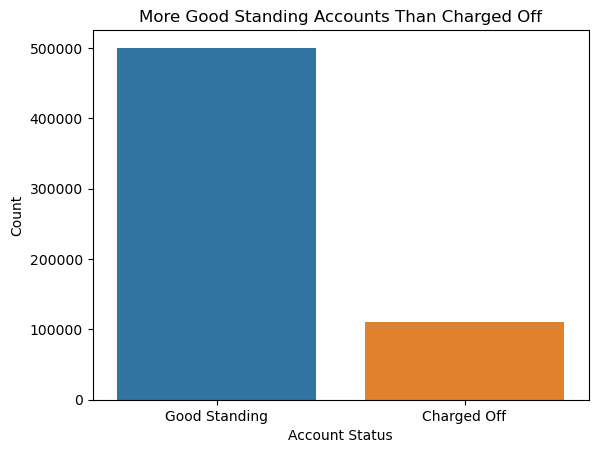

In [37]:
ax = sns.countplot(data = df, x ='target')
ax.set(title = "More Good Standing Accounts Than Charged Off", xlabel = 'Account Status', ylabel = 'Count')
ax.set_xticklabels(['Good Standing', 'Charged Off'])
None

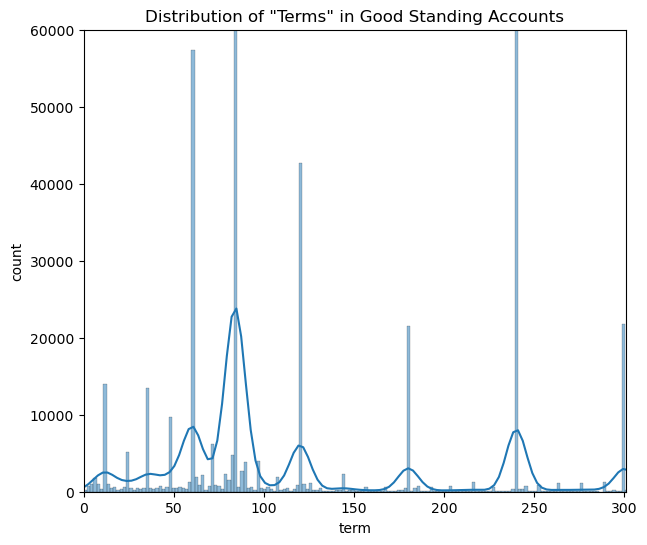

In [38]:
plt.figure(figsize=(7,6))

sns.histplot(data=good, x='term',kde = True)
plt.title('Distribution of "Terms" in Good Standing Accounts')
plt.xlabel('term')
plt.ylabel('count')

plt.xlim(0, 301)
plt.ylim(0, 60000)


plt.show()

In [39]:
# good terms have sum span from 0 - 300

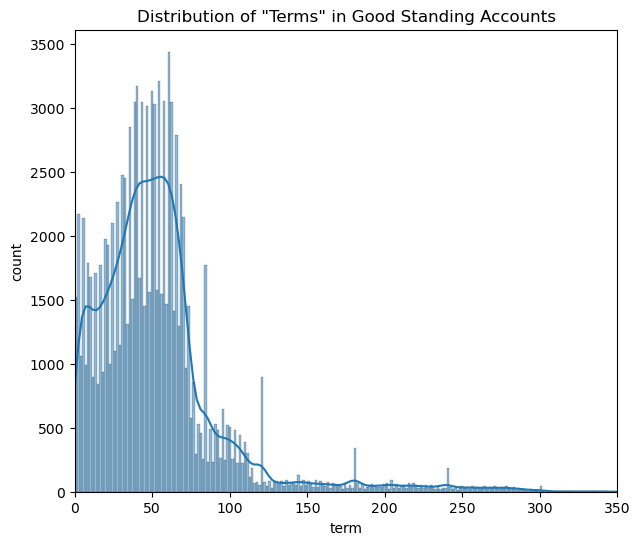

In [40]:
plt.figure(figsize=(7,6))

sns.histplot(data=bad, x='term',kde = True)
plt.title('Distribution of "Terms" in Good Standing Accounts')
plt.xlabel('term')
plt.ylabel('count')

plt.xlim(0, 350)

plt.show()


In [41]:
# bad terms have sum span from 0 - 300 but a majority lies under 120

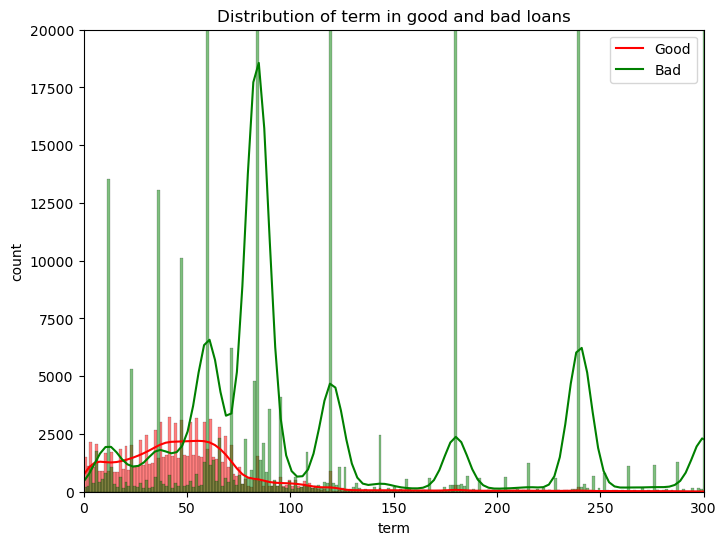

In [42]:
plt.figure(figsize=(8,6))

sns.histplot(data=df, x='term', hue='target', palette=['green', 'red'], kde = True)

plt.title('Distribution of term in good and bad loans')
plt.xlabel('term')
plt.ylabel('count')
plt.legend(labels=['Good', 'Bad'])

plt.xlim(0, 300)
plt.ylim(0, 20000)

plt.show()


In [43]:
# looks like all the off charged accounts are shorter terms. let dive in

In [47]:
df.franchise_code.value_counts()

1        388010
0        197400
78760      1613
21780       617
50564       402
          ...  
25410         1
81605         1
77037         1
39300         1
15930         1
Name: franchise_code, Length: 2246, dtype: int64

In [49]:
df

,zip,term,no_emp,new_exist,create_job,retained_job,franchise_code,urban_rural,rev_line_cr,low_doc,disbursement_gross,balance_gross,chg_off_prin_gr,gr_appv,s_b_a__appv,sec_points,state_score,target
0,47711,84,4,2,0,0,1,0,0,1,60000,0,0,60000,48000,45,3,0
1,46526,60,2,2,0,0,1,0,0,1,40000,0,0,40000,32000,72,3,0
2,47401,180,7,1,0,0,1,0,0,0,287000,0,0,287000,215250,62,3,0
3,74012,60,2,1,0,0,1,0,0,1,35000,0,0,35000,28000,0,3,0
4,32801,240,14,1,7,7,1,0,0,0,229000,0,0,229000,229000,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899158,75062,84,5,2,0,0,1,0,0,1,79000,0,0,79000,63200,0,3,0
899160,43221,60,6,1,0,0,1,0,1,0,85000,0,0,85000,42500,45,3,0
899161,93455,108,26,1,0,0,1,0,0,0,300000,0,0,300000,225000,33,3,0
899162,96830,60,6,1,0,0,1,0,0,1,75000,0,46383,75000,60000,0,3,1
